In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchsummary import summary
import os

os.chdir('../')
from model3d import mri_model
from mri_model import train, get_accuracy
from masks.grad_cam import MriNetGrad

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(47)
np.random.seed(47)
CHECKPOINTS_DIR = './checkpoints/'

In [ ]:
X, y = np.load('./data/tensors.npy'), np.load('./data/labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

## SVM (cross validation)

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
X_f = X.reshape(X.shape[0], -1).copy()
svc = SVC()
cv_results = cross_val_score(svc, X_f, y, cv=10)
print('Average cross-validation accuracy for SVM (10-folds):', np.mean(cv_results))
print('Std cross-validation accuracy for SVM (10-folds):', np.std(cv_results, ddof=1))

## Non-cross-validation training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 
train_dataset = mri_model.MriData(X_train, y_train)
test_dataset = mri_model.MriData(X_test, y_test)
train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
val_loader = torch_data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
EPOCHS = 20
C = 32

In [5]:
model = mri_model.MriNet(C).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
          Dropout-14                [-1

In [6]:
criterion = nn.NLLLoss().to(device)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 45.8454 | Validation 45.9936
Epoch 01/20 || Loss:  Train 2.3479 | Validation 2.5747
Epoch 02/20 || Loss:  Train 0.4535 | Validation 0.5755
Epoch 03/20 || Loss:  Train 0.2501 | Validation 0.3007
Epoch 04/20 || Loss:  Train 0.2415 | Validation 0.2896
Epoch 05/20 || Loss:  Train 0.2286 | Validation 0.3002
Epoch 06/20 || Loss:  Train 0.2197 | Validation 0.2933
Epoch 07/20 || Loss:  Train 0.2639 | Validation 0.3257
Epoch 08/20 || Loss:  Train 0.2155 | Validation 0.3103
Epoch 09/20 || Loss:  Train 0.2244 | Validation 0.2960
Epoch 10/20 || Loss:  Train 0.1838 | Validation 0.2622
Epoch 11/20 || Loss:  Train 0.2835 | Validation 0.4228
Epoch 12/20 || Loss:  Train 0.1776 | Validation 0.2640
Epoch 13/20 || Loss:  Train 0.1484 | Validation 0.2413
Epoch 14/20 || Loss:  Train 0.1756 | Validation 0.2823
Epoch 15/20 || Loss:  Train 0.1395 | Validation 0.2541
Epoch 16/20 || Loss:  Train 0.1173 | Validation 0.2277
Epoch 17/20 || Loss:  Train 0.1130 | Validation 0.2207
Epoch 18

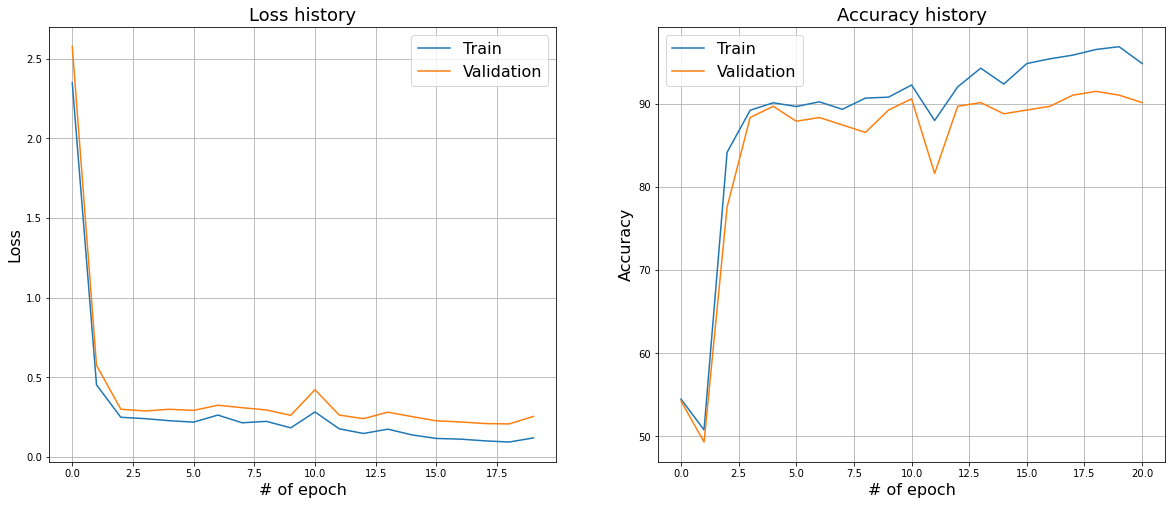

In [7]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

## Train model with grad hook

In [6]:
model = MriNetGrad(C).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()
train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader,device, scheduler=scheduler, save=False)

Epoch 00/20 || Loss:  Train 42.0621 | Validation 42.2451
Epoch 01/20 || Loss:  Train 0.6463 | Validation 0.7124
Epoch 02/20 || Loss:  Train 0.2857 | Validation 0.3526
Epoch 03/20 || Loss:  Train 0.2407 | Validation 0.2997
Epoch 04/20 || Loss:  Train 0.2440 | Validation 0.3228
Epoch 05/20 || Loss:  Train 0.2146 | Validation 0.2814
Epoch 06/20 || Loss:  Train 0.2051 | Validation 0.2814
Epoch 07/20 || Loss:  Train 0.2223 | Validation 0.3235
Epoch 08/20 || Loss:  Train 0.1784 | Validation 0.2561
Epoch 09/20 || Loss:  Train 0.1677 | Validation 0.2585
Epoch 10/20 || Loss:  Train 0.1545 | Validation 0.2462
Epoch 11/20 || Loss:  Train 0.1443 | Validation 0.2303
Epoch 12/20 || Loss:  Train 0.1518 | Validation 0.2778
Epoch 13/20 || Loss:  Train 0.1295 | Validation 0.2420
Epoch 14/20 || Loss:  Train 0.1819 | Validation 0.2882
Epoch 15/20 || Loss:  Train 0.1515 | Validation 0.2863
Epoch 16/20 || Loss:  Train 0.1241 | Validation 0.2393
Epoch 17/20 || Loss:  Train 0.1074 | Validation 0.2254
Epoch 18

## K-Fold training

In [4]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
for train_index, test_index in skf.split(X, y):
    print('Doing {} split'.format(j))
    j += 1
    torch.manual_seed(47)
    np.random.seed(47)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = mri_model.MriData(X_train, y_train)
    test_dataset = mri_model.MriData(X_test, y_test)
    train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch_data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

    model = mri_model.MriNet(C).to(device)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=True) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader, device))


Doing 0 split
Epoch 00/20 || Loss:  Train 25.3967 | Validation 25.1313
Epoch 01/20 || Loss:  Train 0.3261 | Validation 0.3913
Epoch 02/20 || Loss:  Train 0.2694 | Validation 0.3494
Epoch 03/20 || Loss:  Train 0.2531 | Validation 0.3205
Epoch 04/20 || Loss:  Train 0.2512 | Validation 0.3408
Epoch 05/20 || Loss:  Train 0.2240 | Validation 0.2893
Epoch 06/20 || Loss:  Train 0.2234 | Validation 0.2906
Epoch 07/20 || Loss:  Train 0.2003 | Validation 0.2714
Epoch 08/20 || Loss:  Train 0.2001 | Validation 0.2785
Epoch 09/20 || Loss:  Train 0.2071 | Validation 0.2933
Epoch 10/20 || Loss:  Train 0.1888 | Validation 0.2643
Epoch 11/20 || Loss:  Train 0.1855 | Validation 0.2587
Epoch 12/20 || Loss:  Train 0.1830 | Validation 0.2592
Epoch 13/20 || Loss:  Train 0.1798 | Validation 0.2569
Epoch 14/20 || Loss:  Train 0.1839 | Validation 0.2604
Epoch 15/20 || Loss:  Train 0.1783 | Validation 0.2555
Epoch 16/20 || Loss:  Train 0.1730 | Validation 0.2518
Epoch 17/20 || Loss:  Train 0.1723 | Validation 0

In [5]:
print('Mean cross-validation accuracy (10-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (10-folds):', np.std(cross_vall_acc_list, ddof=1))

Mean cross-validation accuracy (10-folds): 91.0199478149414
Std cross-validation accuracy (10-folds): 3.2997303598339243


## Training model on whole data and saving it


In [10]:
dataset = mri_model.MriData(X, y)
loader = torch_data.DataLoader(dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize

model = mri_model.MriNet(C).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
_, _, _, _ = train(EPOCHS, model, criterion, optimizer, loader, loader, device, scheduler=scheduler, save=True, verbose=False,CHECKPOINTS_DIR=CHECKPOINTS_DIR, prefix='_all')

model = MriNetGrad(C).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
_, _, _, _ = train(EPOCHS, model, criterion, optimizer, loader, loader, device, scheduler=scheduler, save=True, verbose=False,CHECKPOINTS_DIR=CHECKPOINTS_DIR, prefix='_all_grad') 